Import Data yang sudah dilakukan cleansing dari database.

In [1]:
# Connect to the database
import pandas as pd
import sqlite3
conn = sqlite3.connect('clean_data_training.db')

# Execute a query and read the results into a DataFrame
query = "SELECT text_clean, label FROM Data_training_clean"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

In [2]:
df

,text_clean,label
0,mohon ulama lurus k212 mmbri hujjah ai diwlh s...,neutral
1,lokasi strategis jalan sumatra bandung nyaman ...,positive
2,betapa bahagia unboxing paket barang bagus tet...,positive
3,aduh mahasiswa sombong kasih kakak kuning ajar...,negative
4,makan agam harga makan food stall 10 kasir sua...,positive
...,...,...
10994,tidak kecewa,positive
10995,enak masakan kepiting senang pilih kepiting se...,positive
10996,hormat ai ai koalisi,neutral
10997,pagi pagi tol pasteur macet parah bikin jengkel,negative


Sortir data dan label berdasarkan sentimen

In [3]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [4]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6415, Neu: 1148, Neg: 3436
Total data: 10999


# **Feature Extraction**

Setelah itu kita lakukan Feature Extraction menggunakan modul "Tokenizer" dan "pad_sequences" dari Tensorflow.

Module Tokenizer memungkinkan untuk memvektorisasi korpus teks, dengan mengubah setiap teks menjadi urutan bilangan bulat (setiap bilangan bulat menjadi indeks token dalam kamus) atau menjadi vektor di mana koefisien untuk setiap token bisa biner, berdasarkan jumlah kata , berdasarkan tf-idf.

Module pad_sequences memungkinkan mengubah list dari sequences menjadi array bentuk 2D.

In [5]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer_lstm = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer_lstm.fit_on_texts(total_data)
with open('tokenizer_lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer_lstm.pickle has created!")

X = tokenizer_lstm.texts_to_sequences(total_data)

vocab_size = len(tokenizer_lstm.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences_lstm.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences_lstm.pickle has created!")


tokenizer_lstm.pickle has created!
x_pad_sequences_lstm.pickle has created!


In [6]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels_lstm.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels_lstm.pickle has created!")

y_labels_lstm.pickle has created!


# **Prepare train & test datasets/Splitting Dataset**

Split dataset menjadi 80% untuk train dan 20% untuk test.

In [7]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences_lstm.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels_lstm.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# **Training**

Jalankan training dengan metode LSTM. Arsitektur LSTM ini dibangun menggunakan framework Tensorflow.

In [8]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

Adapun arsitektur LSTM yang dibangun sebagai berikut:


*   Input Layer: Data teks setelah dilakukan Feature Extraction, dikondisikan menjadi sebuah matrix berdimensi 100.
*   Unit Layer: Pada bagian ini diterapkan unit/neuron sejumlah 64. Pada tahap ini pula fitur Dropout diterapkan guna meminimalisir overfitting.
*   Fully-connected Layer: Setelah proses convolution, dikondisikan sebagai input untuk Multi-layer Perceptron terdiri dari 10 input dan 3 output. Pada tahap ini diimplementasikan pula aktivasi "softmax".

Untuk mencegah overfitting, kita menerapkan EarlyStopping. Sehingga, meskipun epoch belum selesai, training sudah selesai.

In [9]:
embed_dim = 100
units = 64

model_lstm = Sequential()
model_lstm.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model_lstm.add(LSTM(units, dropout=0.2))
model_lstm.add(Dense(3,activation='softmax'))
model_lstm.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_lstm.summary())

adam = optimizers.Adam(learning_rate = 0.001)
model_lstm.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 69, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10


880/880 [==============================] - 104s 108ms/step - loss: 0.4823 - accuracy: 0.8052 - val_loss: 0.3525 - val_accuracy: 0.8673
Epoch 2/10
880/880 [==============================] - 91s 104ms/step - loss: 0.2448 - accuracy: 0.9107 - val_loss: 0.3620 -

# Evaluation

## Confussion Matrix, Accuracy, F1, Recall, Precision

Langkah selanjutnya adalah "Evaluation". Module "classification_report" dari Sklearn merupakan salah satu modul untuk melakukan "Evaluation". Pada tahap evaluasi ini kita akan menerapkan metode evaluasi Accuracy, Precision, Recall dan F1-Score.

In [10]:
from sklearn import metrics

predictions = model_lstm.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 4s 32ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       685
           1       0.76      0.74      0.75       233
           2       0.90      0.91      0.91      1282

    accuracy                           0.86      2200
   macro avg       0.83      0.82      0.83      2200
weighted avg       0.86      0.86      0.86      2200



Hasilnya nilai F1 Score ada pada angka 0.81 untuk Negative, 0.76 untuk Neutral, dan 0.90 untuk Positive. Hasil ini bisa dikatakan cukup bagus untuk sebuah model.

## Cross Validation

Mekanisme evaluasi selanjutnya menggunakan "Cross Validation", yaitu merotasi porsi testing dari dataset agar bisa melihat model yang sudah kita buat stabil ketika dihadapkan pada data yang berbeda.

In [11]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    # model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 18ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       685
           1       0.79      0.70      0.75       233
           2       0.88      0.93      0.90      1282

    accuracy                           0.85      2200
   macro avg       0.83      0.80      0.81      2200
weighted avg       0.85      0.85      0.85      2200

69/69 [==============================] - 3s 20ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       685
           1       0.81      0.65      0.72       233
           2       0.87      0.93      0.90      1282

    accuracy                           0.85      2200
   macro avg       0.84      0.79      0.81      2200
weighted avg       0.85      0.85      0.85      2200

69/69 [==============================] - 3s 24ms/step
Training ke- 3
              precision    reca

Hasilnya nilai rata-rata accuracy pada angka 0.86. Ini menunjukkan model kita cukup stabil pada angka 0.86.

## Visualization

Mekanisme evaluasi selanjutnya menggunakan "Visualization", yaitu mengecek performa training dari arah visualisasinya. Acuan apakah visualisasi bagus atau tidak "Good Fit", sebagai berikut:

**Overfitting**

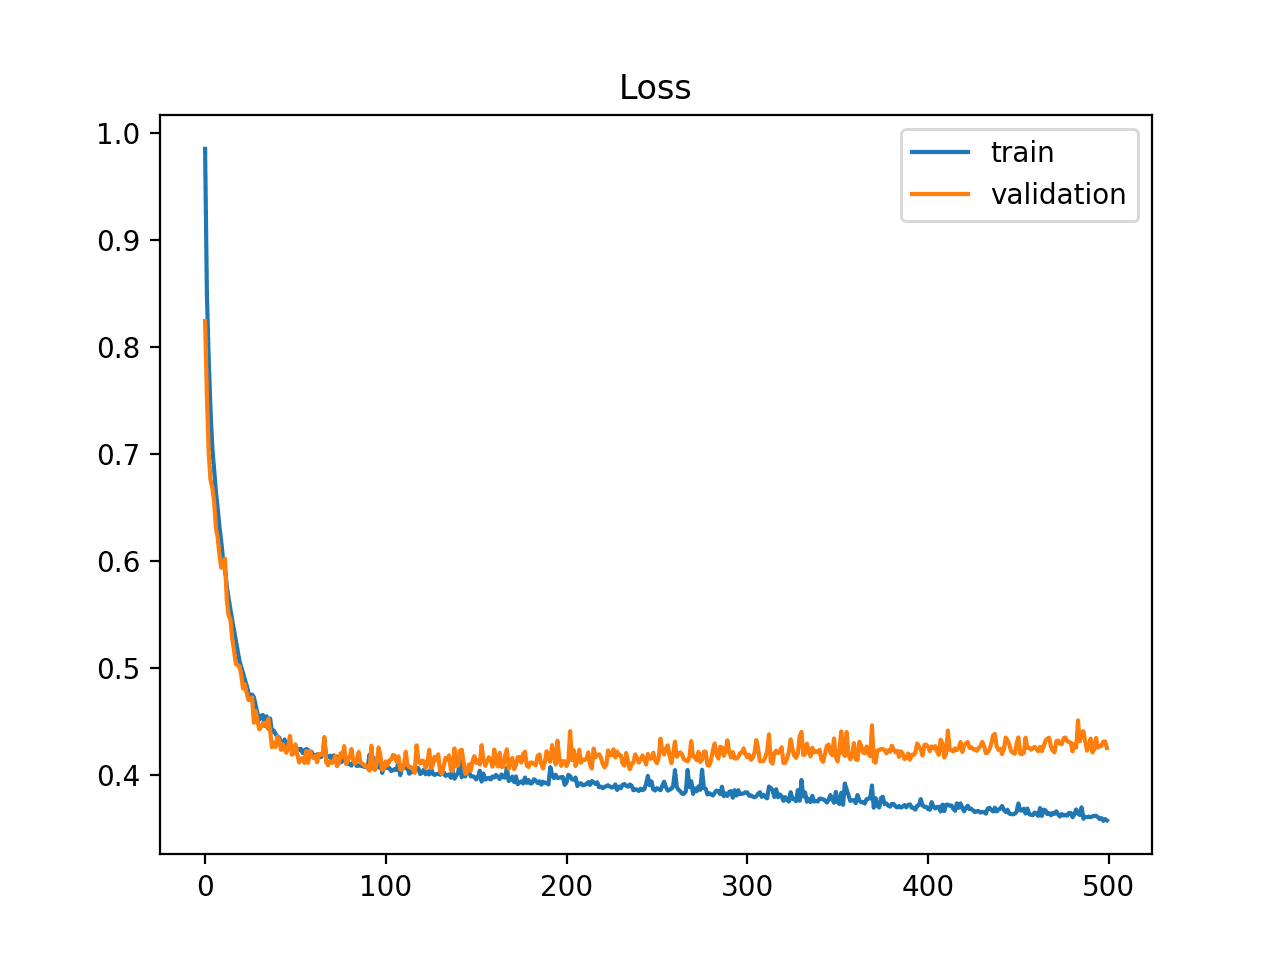

**Underfitting**
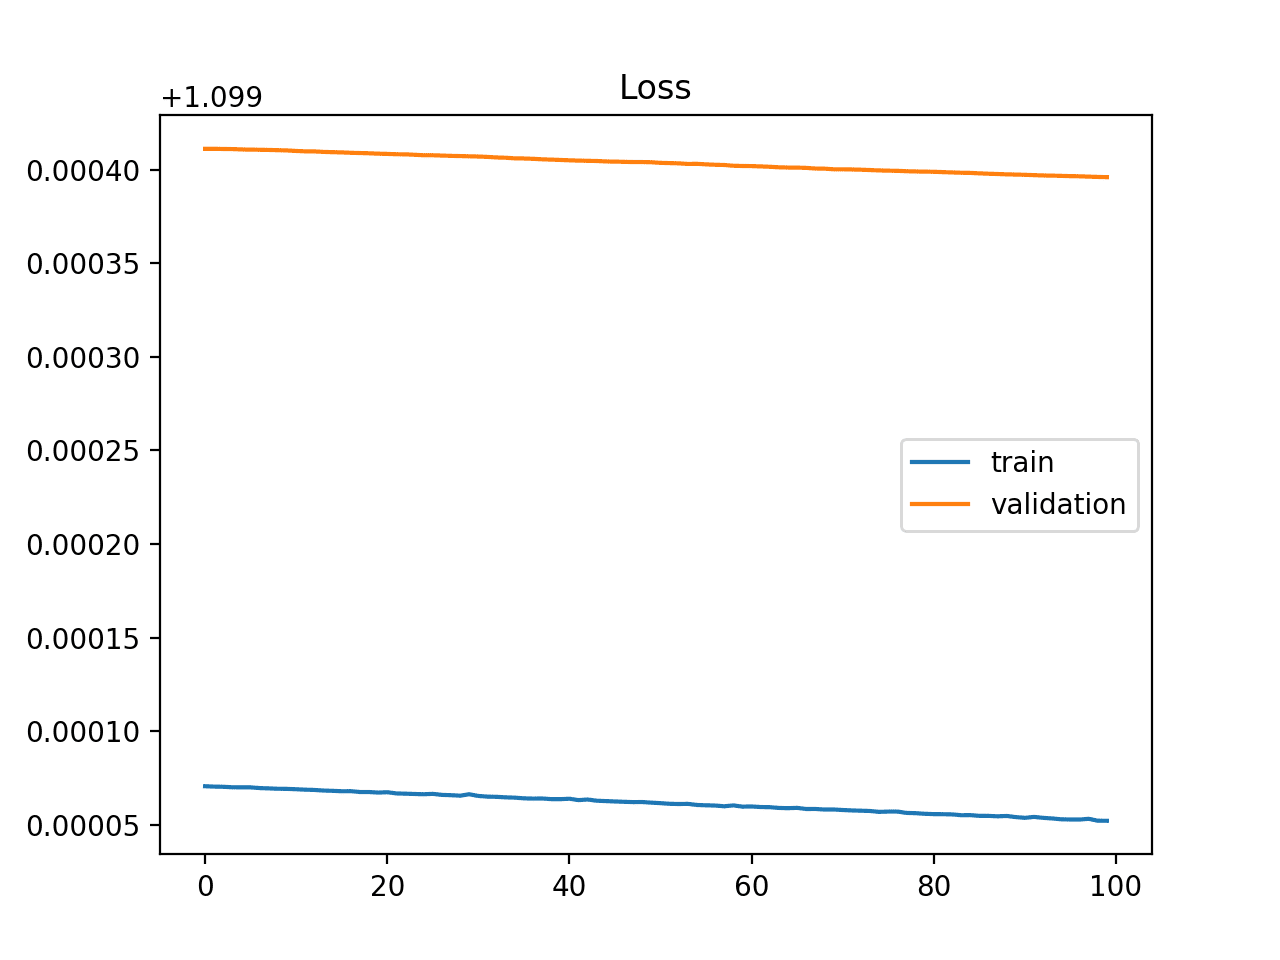

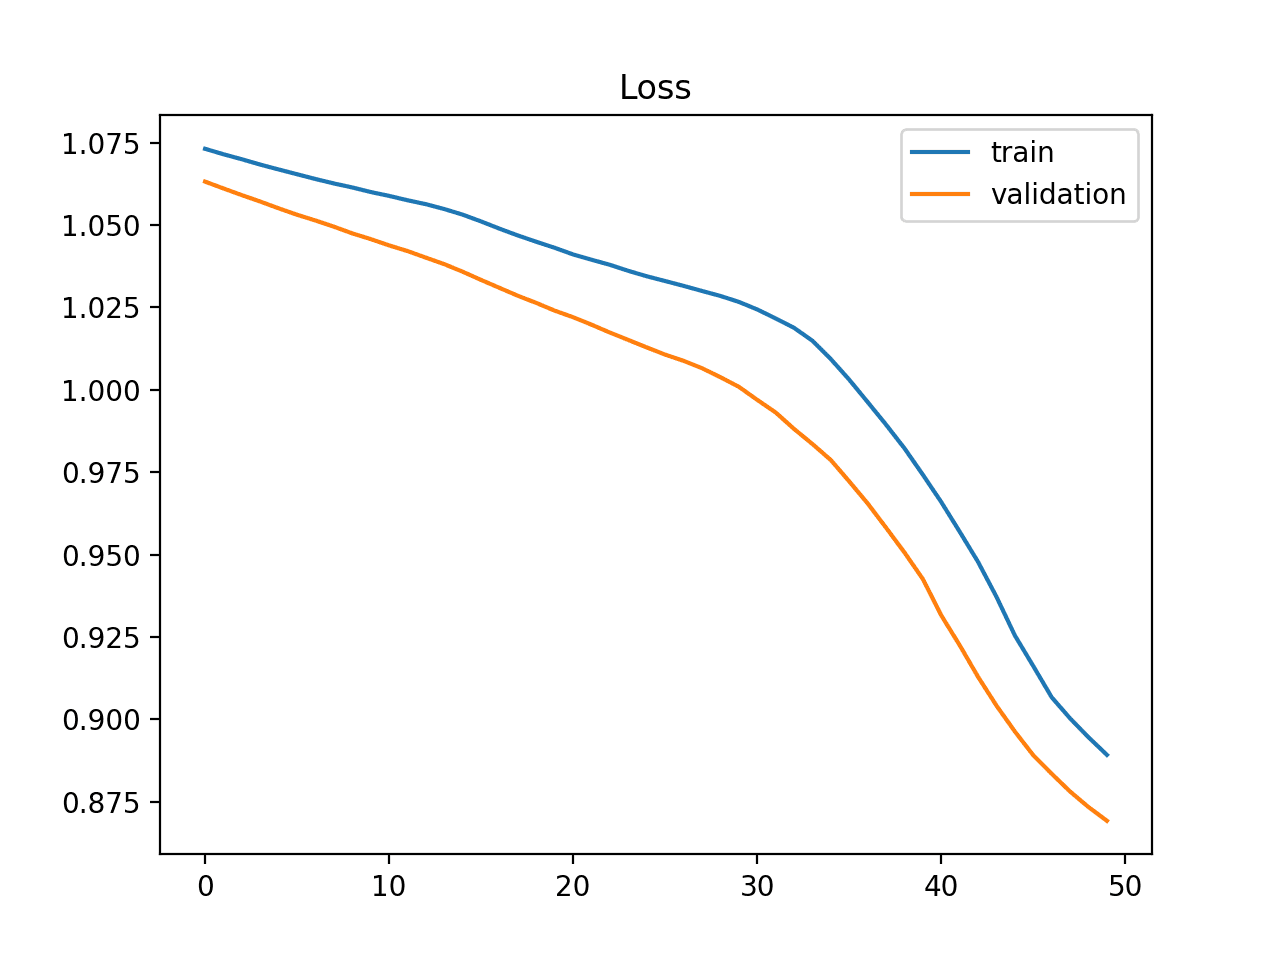

**Good Fit**

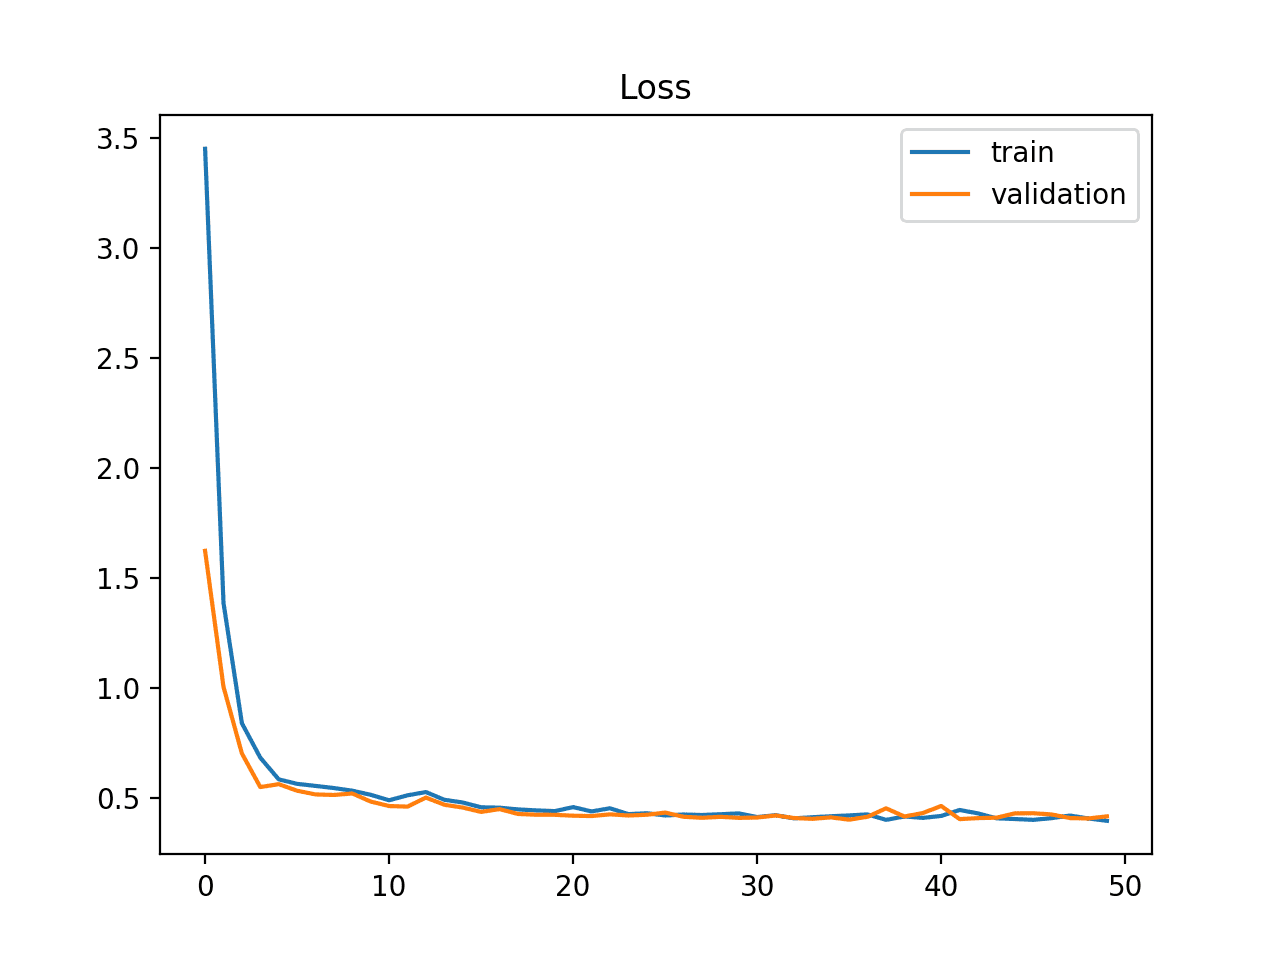

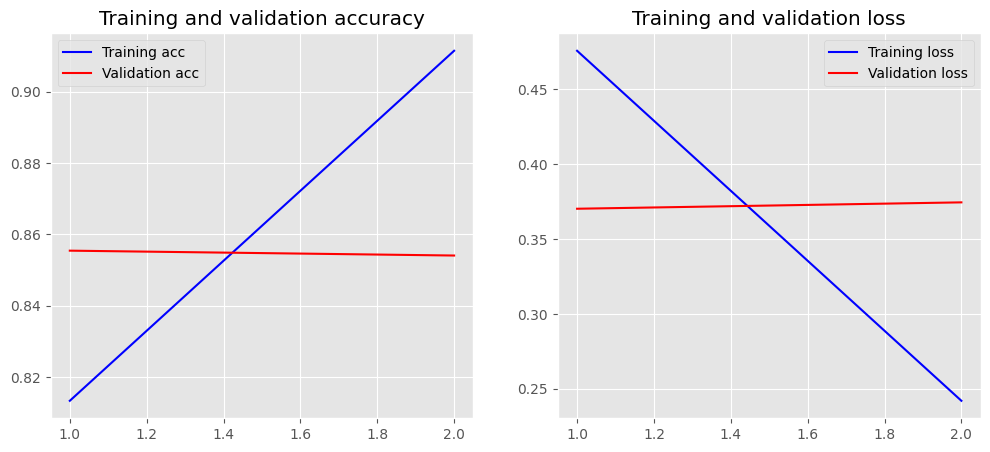

In [12]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

Hasilnya jika kita melihat visualisasinya model yang kita kembangkan tergolong Underfitting. Disinyalir karena:


*   Data training terlalu sedikit
*   Proses training berhenti terlalu cepat. Mungkin saja penerapan EarlyStopping untuk kasus kita tidak terlalu tepat


In [13]:
model.save('model_lstm.h5')
print("Model has created!")

c:\Users\Asani\Documents\GitHub\23001042-15-ACIA-project-gold\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


Cleansing

In [14]:
import re 
import csv
# delete words/char
def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('"rt"',' ',text) # Remove every reTweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = text.strip() #menghapus spasi di awal dan akhir
    text = re.sub(r'\n', ' ', text, flags=re.IGNORECASE)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(r'(.)\1\1+', r'\1', text) #menghapus karakter berulang
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) #menghapus karakter non-alpanumerik
    text = re.sub(r'[øùºðµ¹ª³]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'â', 'a', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text).strip() #menghapus spasi berlebih dan mengganti dengan satu spasi
    text = re.sub(r'^\s+$', '', text) #menghapus seluruh kalimat yg hanya berisi spasi
    text = re.sub(r'https\S+|[^a-zA-Z0-9]', ' ', text) # remove emoticon 
    return text

In [15]:
# Reduce words that start with /x
def remove_words_starting_with_x(text1):
    # Define a pattern to match words starting with \x
    pattern = re.compile(r'\b\\x\w*\b')
    
    # Replace the matched words with an empty string
    text = pattern.sub('', text1)
    
    return text

In [16]:
# func. kamus alay :
def replace_kamusalay(text1):
    # REPLACE TEXT
    replace_words = {}
    with open('Data/Data klasifikasi/new_kamusalay.csv', 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            replace_words[row[0]] = row[1]

    # Replace alay text 
    processed_text = text1  # Define processed_text before the loop
    for word, replacement in replace_words.items():
        processed_text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, processed_text)

    return processed_text

In [17]:
# Stopwords removal and Stemming words  
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stopwordsremoval_and_stemming(text):

     # Tokenize text
    freq_tokens = word_tokenize(text.lower())  # Convert text to lowercase for consistent comparison

    # Get Indonesian and English stopwords
    list_stopwords_id = list(set(stopwords.words('indonesian')))  # Convert set to list
    list_stopwords_en = list(set(stopwords.words('english')))     # Convert set to list

    # Extend the list with additional stopwords
    additional_stopwords = ['ya', 'yg', 'ga', 'yuk', 'dah', 'nya']
    list_stopwords_id.extend(additional_stopwords)

    # Combine Indonesian and English stopwords
    list_stopwords = list_stopwords_id + list_stopwords_en

    # Specify words to retain
    words_to_retain = ['tidak']  # Add more words as needed

    # Remove stopwords from the tokenized text, except words to retain
    tokens_without_stopword = [word for word in freq_tokens if word not in list_stopwords or word in words_to_retain]

    # STemming Indonesian only 
    stemmed_tokens = [stemmer.stem(token) for token in tokens_without_stopword]

    # Reconstruct the text without stopwords
    text_without_stopwords = ' '.join(stemmed_tokens)

    # print(text_without_stopwords)
    return text_without_stopwords

In [18]:
# ALL CLEANSING IN ONE FUNCTION 
# CLEANSING1 for model prediction 

def cleansing_model (data_input):

    text1 = data_input.lower()
    text1 = remove_unnecessary_char(text1)
    text1 = remove_words_starting_with_x(text1)
    text1 = replace_kamusalay(text1)
    text1 = stopwordsremoval_and_stemming(text1)

    return text1

In [19]:
df=pd.read_csv('Data/Data Klasifikasi/abusive.csv')

bannedWord = df["ABUSIVE"].values.tolist()

def RemoveBannedWords(toPrint,database):
    statement = toPrint
    database_1 = sorted(list(database), key=len)
    pattern = re.compile(r"\b(" + "|".join(database_1) + ")\\W", re.I)
    return pattern.sub("", toPrint + ' ')[:-1] #added because it skipped last word

In [20]:
# Load tokenizer from tokenizer.pickle
with open('tokenizer_lstm.pickle', 'rb') as handle:
    tokenizer_lstm = pickle.load(handle)

# Load X from x_pad_sequences.pickle
with open('x_pad_sequences_lstm.pickle', 'rb') as handle:
    X = pickle.load(handle)

In [21]:
import re
from keras.models import load_model

# Rasa syukur, cukup.
input_text = """
bodoh sekali
"""

def cleansing_abbusive_alay(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    string = remove_unnecessary_char(string)
    string = replace_kamusalay(string)
    string = RemoveBannedWords(string,bannedWord)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing_model(input_text)]
predicted = tokenizer_lstm.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Input Text: ",input_text)
print("Sentiment: ",sentiment[polarity])
print("Clean Text: ",cleansing_abbusive_alay(input_text))
# print("Text: ",text[0])

1/1 [==============================] - 2s 2s/step
Input Text:  
bodoh sekali

Sentiment:  negative
Clean Text:  sekali
